In [1]:
# Object Lifecycle Management & Responsibility

[CREATE] Resource(owned)
[CREATE] Resource(temp)
[DEL] Resource(temp)


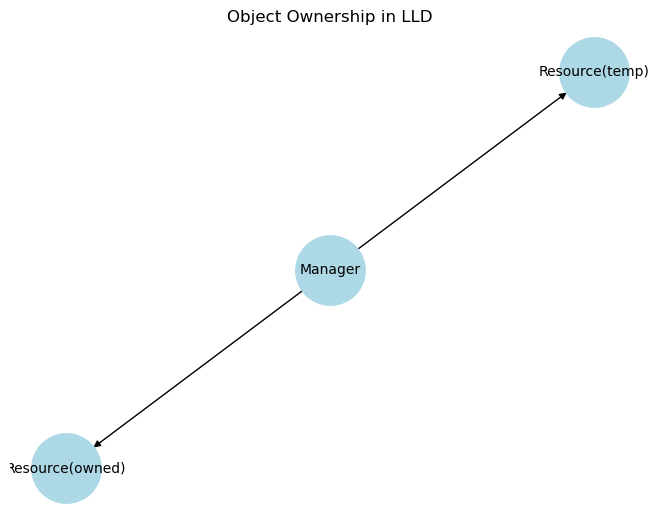

[CLOSE] Resource(owned)
[DEL] Resource(owned)


In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import weakref

# === Classes and Ownership ===
class Resource:
    def __init__(self, name):
        self.name = name
        print(f"[CREATE] Resource({self.name})")

    def close(self):
        print(f"[CLOSE] Resource({self.name})")

    def __del__(self):
        print(f"[DEL] Resource({self.name})")

class Manager:
    def __init__(self):
        self.res_owned = Resource("owned")
        self.res_temp = weakref.ref(Resource("temp"))  # not owning

    def close(self):
        self.res_owned.close()

# === Instantiate and Manage ===
m = Manager()

# === Visualize Ownership ===
G = nx.DiGraph()
G.add_node("Manager", shape='box')
G.add_node("Resource(owned)")
G.add_node("Resource(temp)")

G.add_edges_from([
    ("Manager", "Resource(owned)"),  # strong reference
    ("Manager", "Resource(temp)")    # weak reference
])

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2500, font_size=10, arrows=True)
plt.title("Object Ownership in LLD")
plt.show()

# Cleanup
m.close()
del m  # triggers __del__ of owned Resource only


In [3]:
# Dependency Injection (DI)

[LOG] Creating user Alice
[DB] Executing: INSERT INTO users (name) VALUES ('Alice')


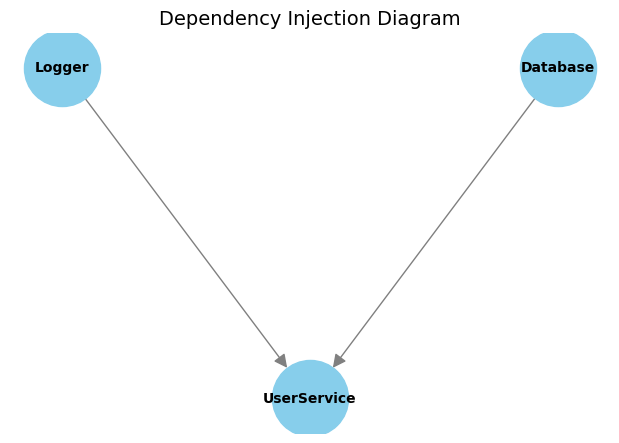

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

# === Dependency Classes ===
class Logger:
    def log(self, message):
        print(f"[LOG] {message}")

class Database:
    def query(self, sql):
        print(f"[DB] Executing: {sql}")

class UserService:
    def __init__(self, logger, database):
        self.logger = logger
        self.database = database

    def create_user(self, name):
        self.logger.log(f"Creating user {name}")
        self.database.query(f"INSERT INTO users (name) VALUES ('{name}')")

# === Inject Dependencies ===
log = Logger()
db = Database()
service = UserService(log, db)
service.create_user("Alice")

# === Visualize Dependency Injection ===
G = nx.DiGraph()

# Add nodes
nodes = {
    "Logger": (0, 1),
    "Database": (2, 1),
    "UserService": (1, 0)
}
G.add_nodes_from(nodes)

# Add edges (injection)
edges = [("Logger", "UserService"), ("Database", "UserService")]
G.add_edges_from(edges)

# Plot
plt.figure(figsize=(6, 4))
pos = nodes
nx.draw(G, pos, with_labels=True, node_color="skyblue", edge_color="gray",
        node_size=3000, font_size=10, font_weight="bold", arrowsize=20)

plt.title("Dependency Injection Diagram", fontsize=14)
plt.axis("off")
plt.show()


In [6]:
# Concurrency-Aware Design

[Actor] Received: Hello 0
[Actor] Received: Hello 0
[Actor] Received: Hello 1
[Actor] Received: Hello 1
[Actor] Received: Hello 2
[Actor] Received: Hello 2
Final Count: 6


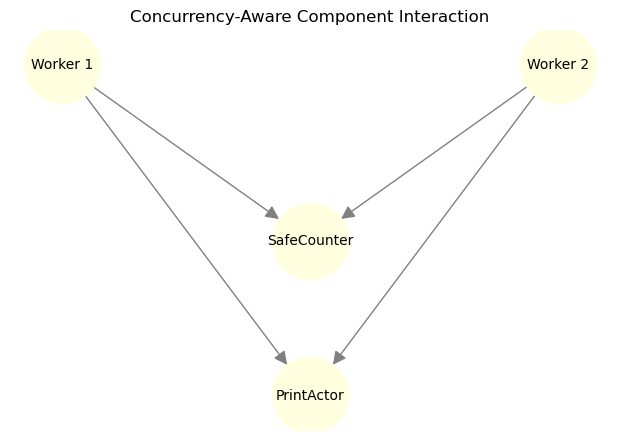

In [7]:
import threading, queue, time
import networkx as nx
import matplotlib.pyplot as plt

# === Thread-safe Counter ===
class SafeCounter:
    def __init__(self):
        self.count = 0
        self.lock = threading.Lock()

    def increment(self):
        with self.lock:
            self.count += 1

# === Actor Model: Message Processor ===
class PrintActor(threading.Thread):
    def __init__(self):
        super().__init__()
        self.q = queue.Queue()
        self.running = True

    def send(self, msg):
        self.q.put(msg)

    def run(self):
        while self.running:
            msg = self.q.get()
            if msg == "STOP":
                break
            print(f"[Actor] Received: {msg}")

# === Launch Threads ===
counter = SafeCounter()
actor = PrintActor()
actor.start()

def worker():
    for i in range(3):
        counter.increment()
        actor.send(f"Hello {i}")
        time.sleep(0.1)

t1 = threading.Thread(target=worker)
t2 = threading.Thread(target=worker)
t1.start(); t2.start(); t1.join(); t2.join()

actor.send("STOP")
actor.join()

print(f"Final Count: {counter.count}")

# === Visualize Component Concurrency ===
G = nx.DiGraph()
positions = {
    "Worker 1": (0, 1),
    "Worker 2": (2, 1),
    "SafeCounter": (1, 0.2),
    "PrintActor": (1, -0.5)
}
G.add_nodes_from(positions)
G.add_edges_from([
    ("Worker 1", "SafeCounter"),
    ("Worker 2", "SafeCounter"),
    ("Worker 1", "PrintActor"),
    ("Worker 2", "PrintActor")
])

plt.figure(figsize=(6, 4))
nx.draw(G, positions, with_labels=True, node_color="lightyellow", node_size=3000,
        font_size=10, arrowsize=20, edge_color='gray')
plt.title("Concurrency-Aware Component Interaction")
plt.axis("off")
plt.show()


In [8]:
# Message Passing & Event-Driven Design

[UserService] Created user Alice
[Logger] User created: Alice
[Email] Sent welcome email to: Alice


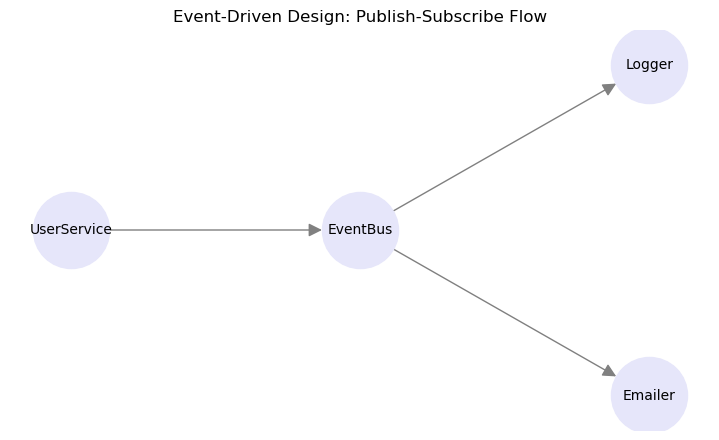

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

# === Event Bus (Publisher-Subscriber) ===
class EventBus:
    def __init__(self):
        self.subscribers = {}

    def subscribe(self, event_name, handler):
        self.subscribers.setdefault(event_name, []).append(handler)

    def publish(self, event_name, data):
        for handler in self.subscribers.get(event_name, []):
            handler(data)

# === Listener Components ===
def logger_handler(data):
    print(f"[Logger] User created: {data['name']}")

def email_handler(data):
    print(f"[Email] Sent welcome email to: {data['name']}")

# === Business Logic ===
class UserService:
    def __init__(self, event_bus):
        self.event_bus = event_bus

    def create_user(self, name):
        print(f"[UserService] Created user {name}")
        self.event_bus.publish("user_created", {"name": name})

# === Setup Event Flow ===
bus = EventBus()
bus.subscribe("user_created", logger_handler)
bus.subscribe("user_created", email_handler)

service = UserService(bus)
service.create_user("Alice")

# === Diagram of Event Flow ===
G = nx.DiGraph()
pos = {
    "UserService": (0, 0),
    "EventBus": (1.5, 0),
    "Logger": (3, 1),
    "Emailer": (3, -1)
}
G.add_nodes_from(pos)
G.add_edges_from([
    ("UserService", "EventBus"),
    ("EventBus", "Logger"),
    ("EventBus", "Emailer")
])

plt.figure(figsize=(7, 4))
nx.draw(G, pos, with_labels=True, node_color="lavender", node_size=3000,
        arrows=True, font_size=10, arrowsize=20, edge_color="gray")
plt.title("Event-Driven Design: Publish-Subscribe Flow")
plt.axis("off")
plt.show()


In [10]:
# Module Design, API Boundaries & Contracts

[DB] INSERT INTO users(name) VALUES('Alice')
[Logger] User 'Alice' created


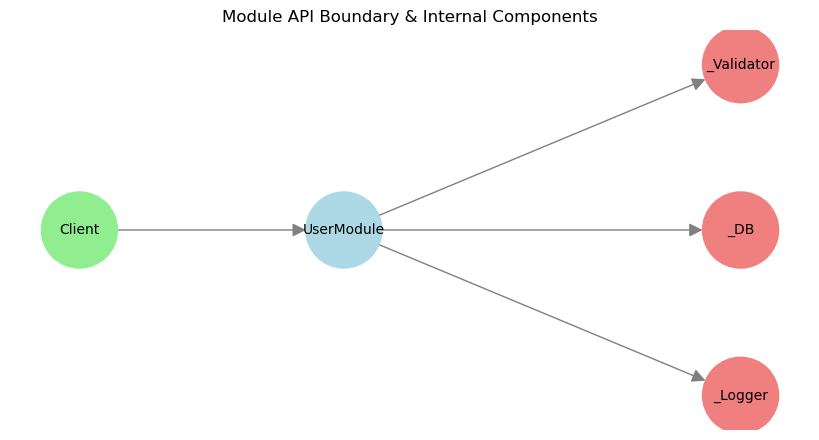

In [11]:
import networkx as nx
import matplotlib.pyplot as plt

# === Internal Components ===
class _Logger:
    def log(self, msg):
        print(f"[Logger] {msg}")

class _Validator:
    def validate(self, name):
        if not name:
            raise ValueError("Name is required")

class _DB:
    def save(self, name):
        print(f"[DB] INSERT INTO users(name) VALUES('{name}')")

# === Public API ===
class UserModule:
    def __init__(self):
        self._logger = _Logger()
        self._validator = _Validator()
        self._db = _DB()

    def create_user(self, name):
        self._validator.validate(name)
        self._db.save(name)
        self._logger.log(f"User '{name}' created")

# === Client ===
mod = UserModule()
mod.create_user("Alice")

# === Diagram: Internal vs Public API ===
G = nx.DiGraph()
pos = {
    "Client": (-1, 0),
    "UserModule": (0, 0),
    "_Validator": (1.5, 1),
    "_DB": (1.5, 0),
    "_Logger": (1.5, -1)
}

G.add_nodes_from(pos)
G.add_edges_from([
    ("Client", "UserModule"),
    ("UserModule", "_Validator"),
    ("UserModule", "_DB"),
    ("UserModule", "_Logger")
])

# Color public vs internal
color_map = []
for node in G.nodes:
    if node.startswith("_"):
        color_map.append("lightcoral")  # internal
    elif node == "UserModule":
        color_map.append("lightblue")   # API
    else:
        color_map.append("lightgreen")  # caller

plt.figure(figsize=(8, 4))
nx.draw(G, pos, with_labels=True, node_color=color_map, node_size=3000,
        arrows=True, font_size=10, arrowsize=20, edge_color="gray")
plt.title("Module API Boundary & Internal Components")
plt.axis("off")
plt.show()


In [12]:
# Componentization & Services

[Auth] Authenticated token: 123abc
[Orchestrator] User onboarded: Alice
[Notify] Welcome email sent to Alice


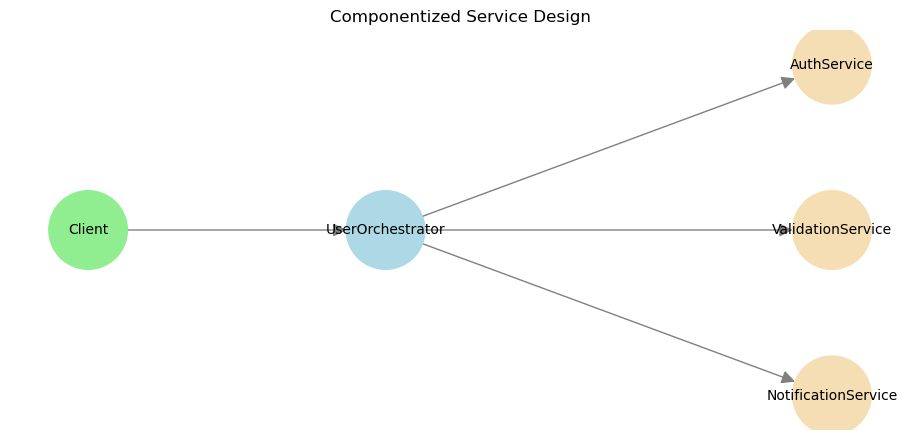

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

# === Independent Services ===
class AuthService:
    def authenticate(self, token):
        print(f"[Auth] Authenticated token: {token}")
        return True

class ValidationService:
    def validate_user_data(self, name):
        if not name:
            raise ValueError("Invalid user name")

class NotificationService:
    def send_welcome(self, name):
        print(f"[Notify] Welcome email sent to {name}")

# === Orchestrator ===
class UserOrchestrator:
    def __init__(self, auth, validator, notifier):
        self.auth = auth
        self.validator = validator
        self.notifier = notifier

    def onboard_user(self, name, token):
        if self.auth.authenticate(token):
            self.validator.validate_user_data(name)
            print(f"[Orchestrator] User onboarded: {name}")
            self.notifier.send_welcome(name)

# === Run ===
auth = AuthService()
validator = ValidationService()
notifier = NotificationService()
controller = UserOrchestrator(auth, validator, notifier)

controller.onboard_user("Alice", token="123abc")

# === Diagram of Componentization ===
G = nx.DiGraph()
pos = {
    "Client": (-1, 0),
    "UserOrchestrator": (0, 0),
    "AuthService": (1.5, 1),
    "ValidationService": (1.5, 0),
    "NotificationService": (1.5, -1)
}
G.add_nodes_from(pos)
G.add_edges_from([
    ("Client", "UserOrchestrator"),
    ("UserOrchestrator", "AuthService"),
    ("UserOrchestrator", "ValidationService"),
    ("UserOrchestrator", "NotificationService")
])

color_map = ["lightgreen" if n == "Client" else 
             "lightblue" if n == "UserOrchestrator" else 
             "wheat" for n in G.nodes]

plt.figure(figsize=(9, 4))
nx.draw(G, pos, with_labels=True, node_color=color_map, node_size=3200,
        font_size=10, arrowsize=20, edge_color="gray")
plt.title("Componentized Service Design")
plt.axis("off")
plt.show()


In [14]:
# State Machines & Protocol Modeling

Order paid
Order shipped
Order delivered


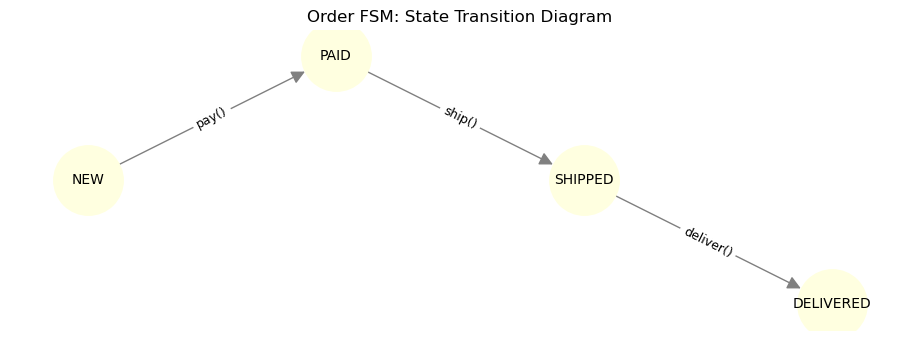

In [15]:
import networkx as nx
import matplotlib.pyplot as plt

# === Order FSM ===
class Order:
    def __init__(self):
        self.state = "NEW"

    def pay(self):
        if self.state == "NEW":
            self.state = "PAID"
            print("Order paid")
        else:
            print("Invalid transition: pay")

    def ship(self):
        if self.state == "PAID":
            self.state = "SHIPPED"
            print("Order shipped")
        else:
            print("Invalid transition: ship")

    def deliver(self):
        if self.state == "SHIPPED":
            self.state = "DELIVERED"
            print("Order delivered")
        else:
            print("Invalid transition: deliver")

# === Simulate Transitions ===
order = Order()
order.pay()
order.ship()
order.deliver()

# === FSM Transition Diagram ===
G = nx.DiGraph()
transitions = [
    ("NEW", "PAID", "pay()"),
    ("PAID", "SHIPPED", "ship()"),
    ("SHIPPED", "DELIVERED", "deliver()")
]

for src, dst, label in transitions:
    G.add_edge(src, dst, label=label)

pos = {
    "NEW": (0, 0),
    "PAID": (1.5, 1),
    "SHIPPED": (3, 0),
    "DELIVERED": (4.5, -1)
}

plt.figure(figsize=(9, 3))
nx.draw(G, pos, with_labels=True, node_size=2500, node_color='lightyellow',
        font_size=10, arrowsize=20, edge_color='gray')

# Edge labels
edge_labels = {(u, v): d['label'] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

plt.title("Order FSM: State Transition Diagram")
plt.axis("off")
plt.show()


In [16]:
# Resource Pooling

[Pool] Acquired Conn-0
Client-0 using Conn-0
[Pool] Acquired Conn-1
Client-1 using Conn-1
[Pool] Released Conn-0
[Pool] Acquired Conn-0
Client-2 using Conn-0
[Pool] Released Conn-1
[Pool] Released Conn-0
All clients done.


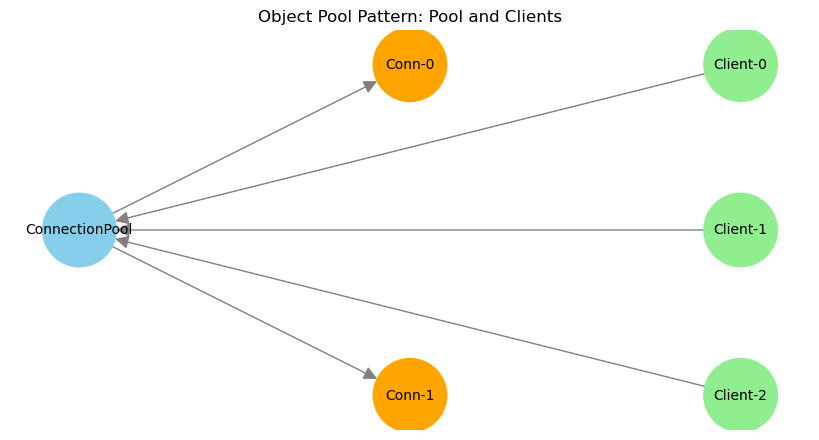

In [17]:
import queue
import threading
import networkx as nx
import matplotlib.pyplot as plt
import time

# === Simple Connection ===
class Connection:
    def __init__(self, id):
        self.id = id

    def __repr__(self):
        return f"Conn-{self.id}"

# === Connection Pool ===
class ConnectionPool:
    def __init__(self, maxsize):
        self.pool = queue.Queue(maxsize)
        for i in range(maxsize):
            self.pool.put(Connection(i))

    def acquire(self):
        conn = self.pool.get()
        print(f"[Pool] Acquired {conn}")
        return conn

    def release(self, conn):
        print(f"[Pool] Released {conn}")
        self.pool.put(conn)

# === Simulate Clients Acquiring and Releasing ===
def client_task(pool, client_id):
    conn = pool.acquire()
    print(f"Client-{client_id} using {conn}")
    time.sleep(0.5)  # simulate work
    pool.release(conn)

pool = ConnectionPool(2)
threads = []
for i in range(3):
    t = threading.Thread(target=client_task, args=(pool, i))
    threads.append(t)
    t.start()

for t in threads:
    t.join()

print("All clients done.")

# === Diagram of Pool & Clients ===
G = nx.DiGraph()
pos = {
    "ConnectionPool": (0, 0),
    "Client-0": (2, 1),
    "Client-1": (2, 0),
    "Client-2": (2, -1),
    "Conn-0": (1, 1),
    "Conn-1": (1, -1)
}

G.add_nodes_from(pos)
G.add_edges_from([
    ("ConnectionPool", "Conn-0"),
    ("ConnectionPool", "Conn-1"),
    ("Client-0", "ConnectionPool"),
    ("Client-1", "ConnectionPool"),
    ("Client-2", "ConnectionPool")
])

colors = []
for n in G.nodes:
    if n.startswith("Client"):
        colors.append("lightgreen")
    elif n == "ConnectionPool":
        colors.append("skyblue")
    else:
        colors.append("orange")

plt.figure(figsize=(8, 4))
nx.draw(G, pos, with_labels=True, node_color=colors, node_size=2800,
        arrows=True, font_size=10, arrowsize=20, edge_color='gray')
plt.title("Object Pool Pattern: Pool and Clients")
plt.axis("off")
plt.show()


In [18]:
# Layered Architecture

User name is Alice


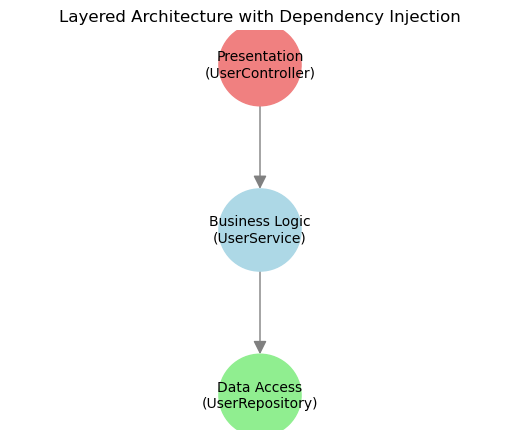

In [19]:
import networkx as nx
import matplotlib.pyplot as plt

# === Data Access Layer ===
class UserRepository:
    def get_user(self, user_id):
        return {"id": user_id, "name": "Alice"}

# === Business Logic Layer ===
class UserService:
    def __init__(self, user_repo):
        self.user_repo = user_repo  # Dependency Injection

    def get_user_name(self, user_id):
        user = self.user_repo.get_user(user_id)
        return user["name"]

# === Presentation Layer ===
class UserController:
    def __init__(self, user_service):
        self.user_service = user_service  # Dependency Injection

    def show_user(self, user_id):
        name = self.user_service.get_user_name(user_id)
        print(f"User name is {name}")

# === Setup dependencies ===
repo = UserRepository()
service = UserService(repo)
controller = UserController(service)

controller.show_user(42)

# === Diagram of Layers ===
G = nx.DiGraph()
pos = {
    "Presentation\n(UserController)": (0, 2),
    "Business Logic\n(UserService)": (0, 1),
    "Data Access\n(UserRepository)": (0, 0)
}

G.add_nodes_from(pos)
G.add_edges_from([
    ("Presentation\n(UserController)", "Business Logic\n(UserService)"),
    ("Business Logic\n(UserService)", "Data Access\n(UserRepository)")
])

colors = ["lightcoral", "lightblue", "lightgreen"]

plt.figure(figsize=(5, 4))
nx.draw(G, pos, with_labels=True, node_color=colors, node_size=3500,
        arrows=True, font_size=10, arrowsize=20, edge_color="gray")
plt.title("Layered Architecture with Dependency Injection")
plt.axis("off")
plt.show()


In [20]:
# Event-Driven Architecture & Message Queues

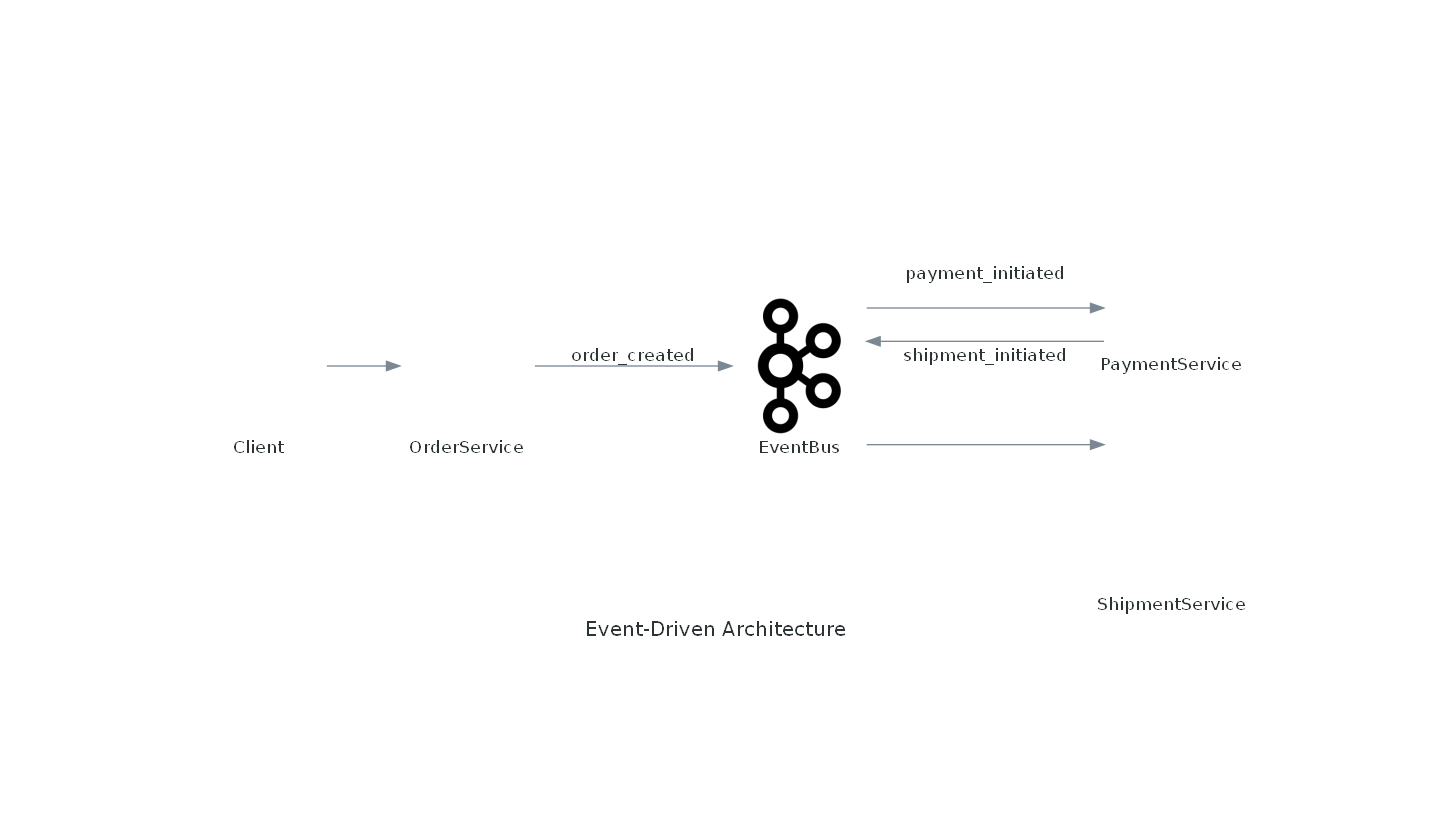

In [23]:
from diagrams import Diagram, Edge
from diagrams.generic.blank import Blank
from diagrams.onprem.queue import Kafka
from PIL import Image
import IPython.display as display
import os

# === Generate Diagram Image ===
with Diagram("Event-Driven Architecture", show=False, outformat="png", filename="event_flow_diagram"):
    client = Blank("Client")
    event_bus = Kafka("EventBus")
    order = Blank("OrderService")
    payment = Blank("PaymentService")
    shipment = Blank("ShipmentService")

    client >> order >> Edge(label="order_created") >> event_bus
    event_bus >> Edge(label="payment_initiated") >> payment
    payment >> Edge(label="shipment_initiated") >> event_bus
    event_bus >> shipment

# === Display the generated PNG inside Jupyter ===
img = Image.open("event_flow_diagram.png")
display.display(img)


In [24]:
# Event Sourcing

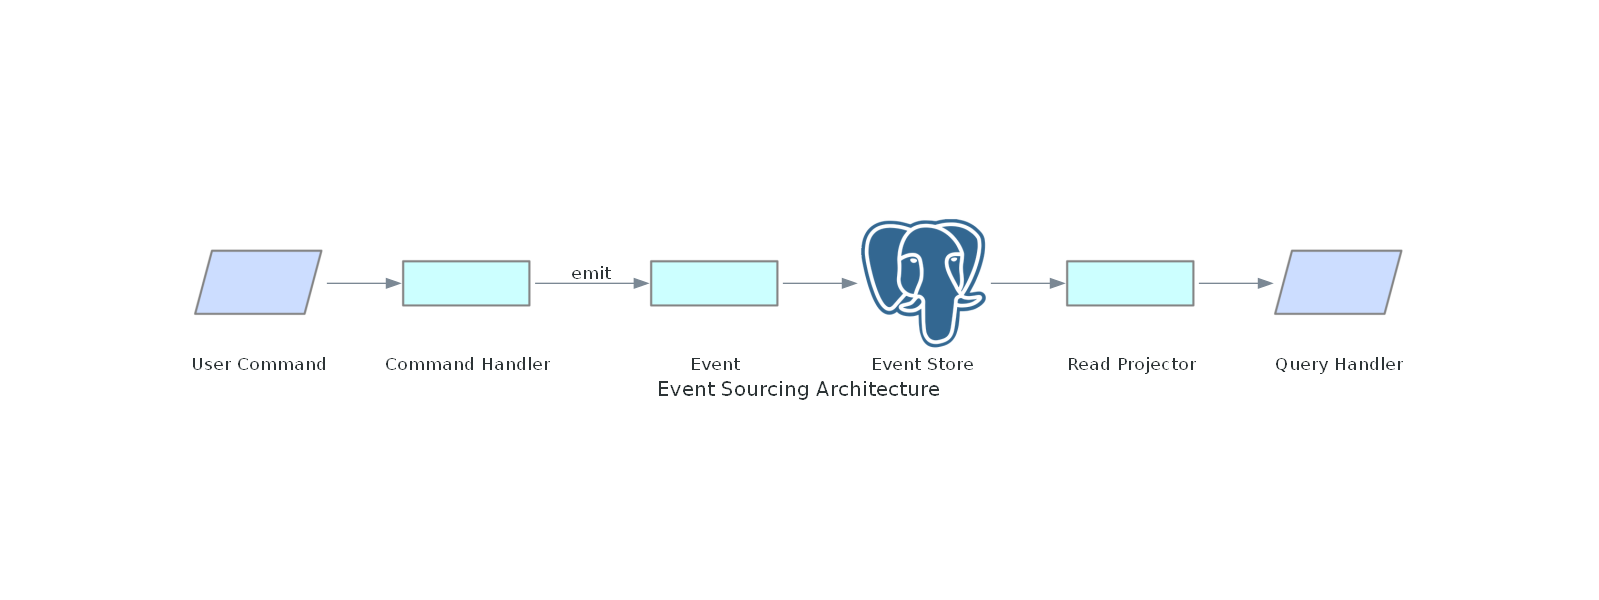

In [25]:
from diagrams import Diagram, Edge
from diagrams.programming.flowchart import Action, InputOutput
from diagrams.onprem.queue import Kafka
from diagrams.onprem.database import PostgreSQL
from PIL import Image
import IPython.display as display

# === Event Sourcing Architecture Diagram ===
with Diagram("Event Sourcing Architecture", show=False, outformat="png", filename="event_sourcing_diagram"):
    user = InputOutput("User Command")
    handler = Action("Command Handler")
    event = Action("Event")
    store = PostgreSQL("Event Store")
    projector = Action("Read Projector")
    reader = InputOutput("Query Handler")

    user >> handler >> Edge(label="emit") >> event >> store
    store >> projector >> reader

# === Display the generated diagram ===
img = Image.open("event_sourcing_diagram.png")
display.display(img)


In [27]:
# Hexagonal Architecture (Ports and Adapters)

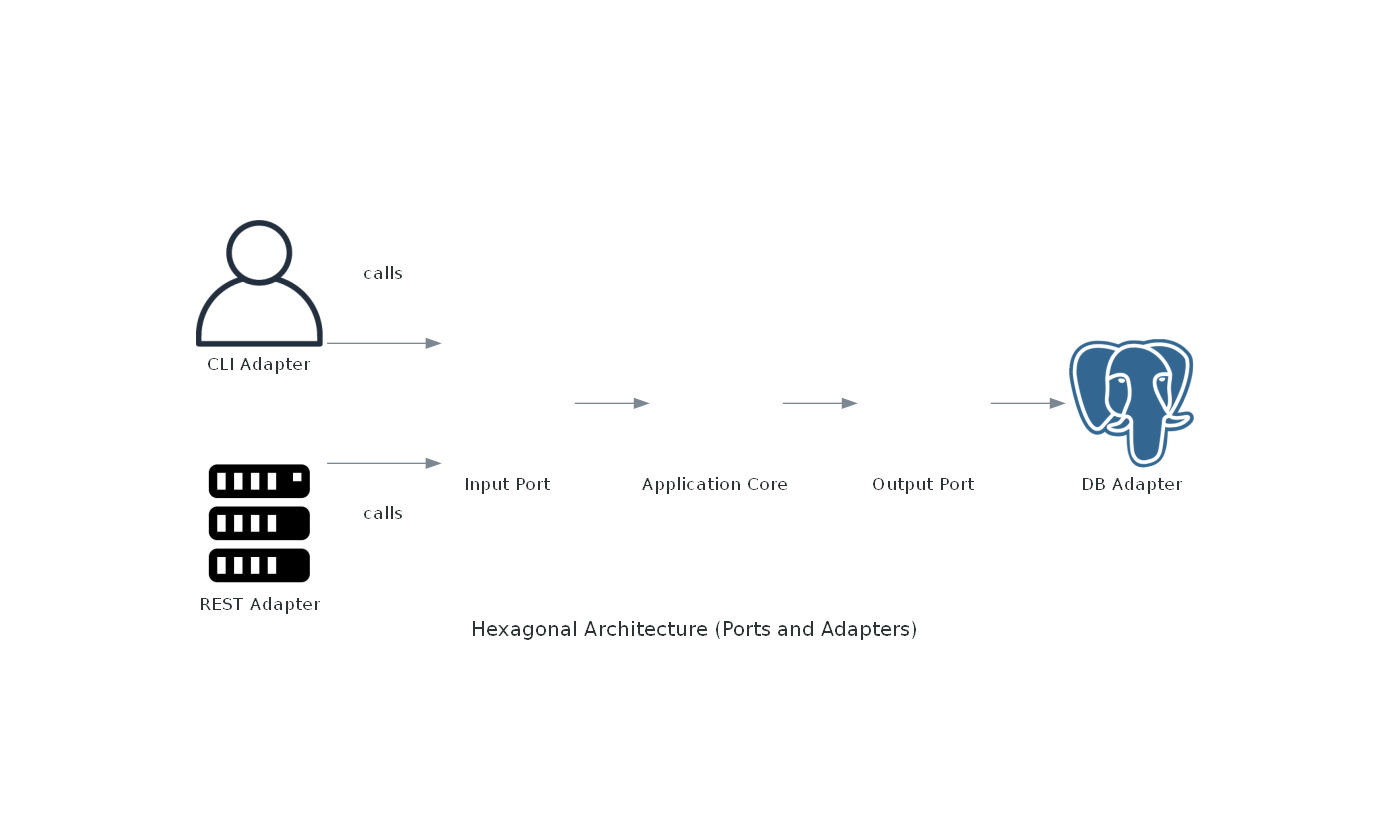

In [28]:
from diagrams import Diagram, Edge
from diagrams.generic.blank import Blank
from diagrams.onprem.database import PostgreSQL
from diagrams.onprem.client import User
from diagrams.onprem.compute import Server
from PIL import Image
import IPython.display as display

with Diagram("Hexagonal Architecture (Ports and Adapters)", show=False, outformat="png", filename="hex_architecture"):
    # Adapters
    cli = User("CLI Adapter")
    rest = Server("REST Adapter")
    db = PostgreSQL("DB Adapter")

    # Application Core
    app_core = Blank("Application Core")

    # Ports (interfaces)
    input_port = Blank("Input Port")
    output_port = Blank("Output Port")

    cli >> Edge(label="calls") >> input_port >> app_core
    rest >> Edge(label="calls") >> input_port
    app_core >> output_port >> db

# Display the image
img = Image.open("hex_architecture.png")
display.display(img)


In [29]:
# Centralized Communication

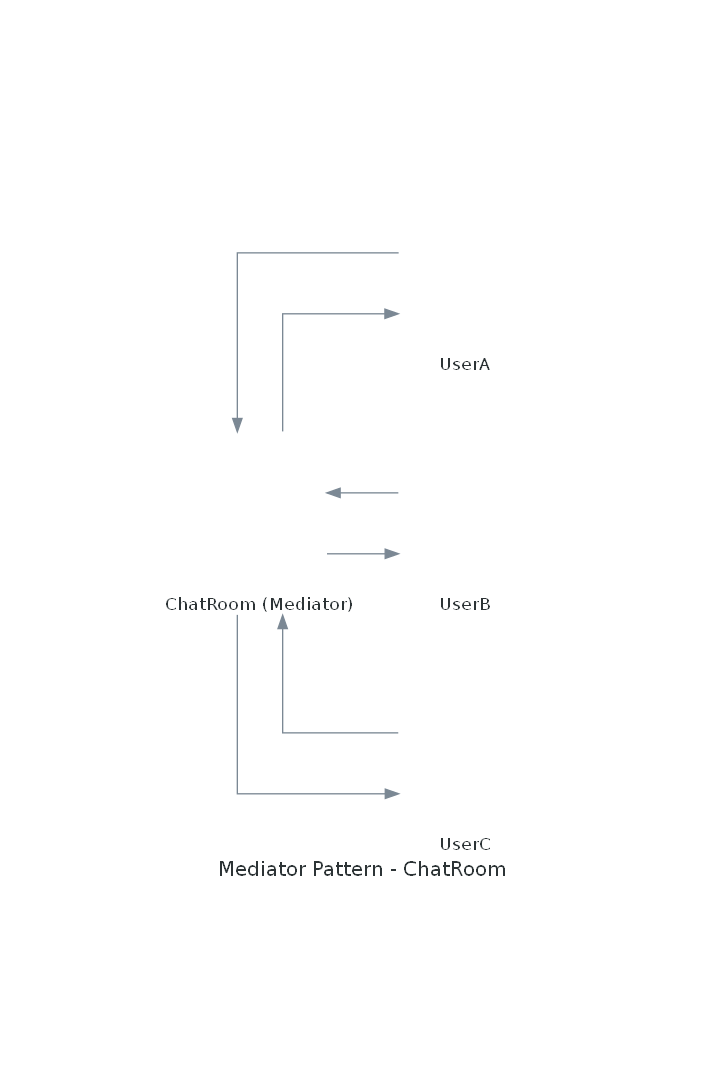

In [30]:
from diagrams import Diagram
from diagrams.generic.blank import Blank
from PIL import Image
import IPython.display as display

# === Diagram: Mediator and Colleagues ===
with Diagram("Mediator Pattern - ChatRoom", show=False, outformat="png", filename="mediator_chatroom"):
    mediator = Blank("ChatRoom (Mediator)")
    user1 = Blank("UserA")
    user2 = Blank("UserB")
    user3 = Blank("UserC")

    user1 >> mediator
    user2 >> mediator
    user3 >> mediator

    mediator >> user1
    mediator >> user2
    mediator >> user3

img = Image.open("mediator_chatroom.png")
display.display(img)


In [31]:
# Thread-safe Singleton & Resource Locking

ConfigManager Initialized
[Thread 0] Got instance: 1928106631264
[Thread 1] Got instance: 1928106631264
[Thread 2] Got instance: 1928106631264
[Thread 3] Got instance: 1928106631264
[Thread 4] Got instance: 1928106631264


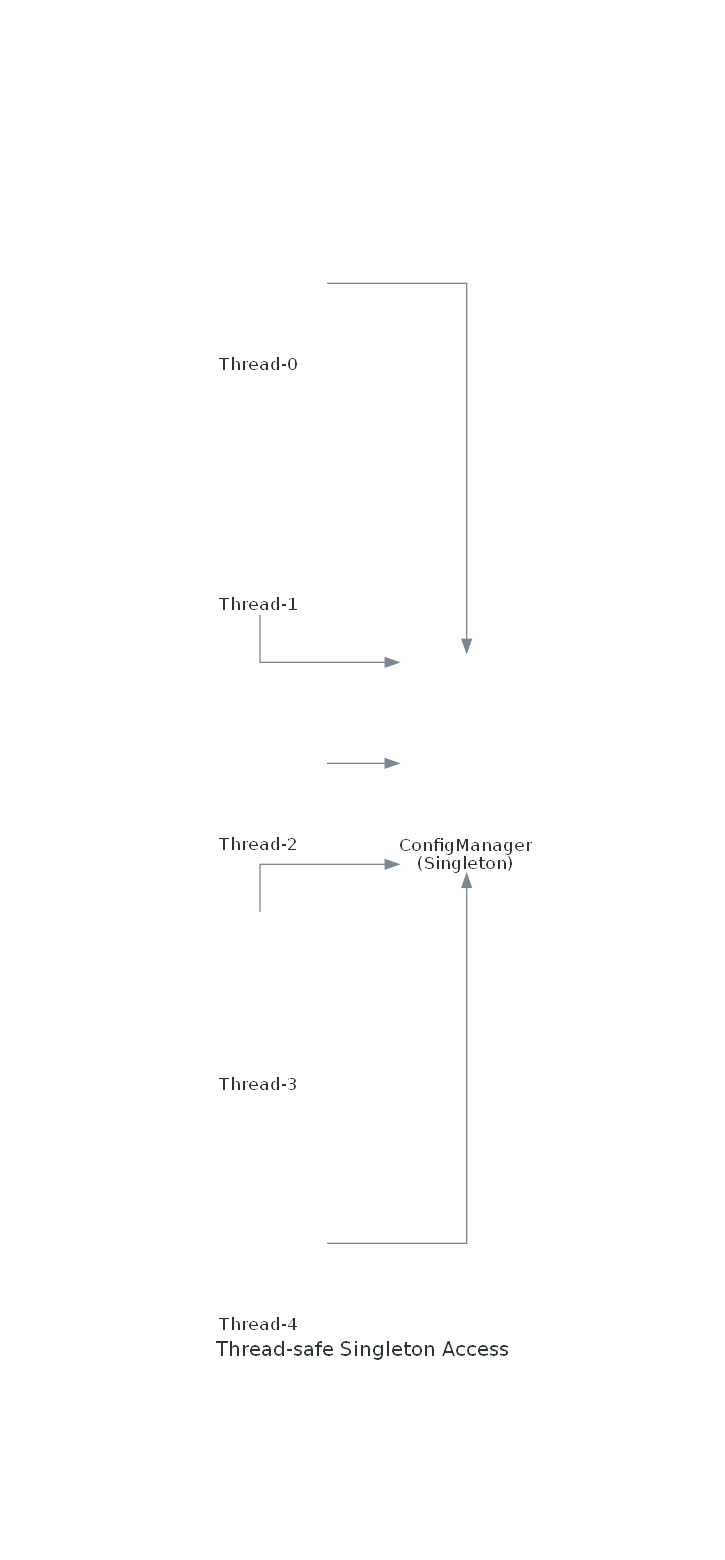

In [33]:
import threading
from time import sleep
from PIL import Image
import IPython.display as display
from diagrams import Diagram
from diagrams.generic.blank import Blank

# === Singleton with Thread Safety ===
class SingletonMeta(type):
    _instance = None
    _lock = threading.Lock()

    def __call__(cls, *args, **kwargs):
        # Double-checked locking
        if not cls._instance:
            with cls._lock:
                if not cls._instance:
                    cls._instance = super().__call__(*args, **kwargs)
        return cls._instance

class ConfigManager(metaclass=SingletonMeta):
    def __init__(self):
        print("ConfigManager Initialized")
        self.config = {"theme": "dark"}

# === Test Singleton from multiple threads ===
def worker():
    inst = ConfigManager()
    print(f"[Thread {threading.current_thread().name}] Got instance: {id(inst)}")

threads = [threading.Thread(target=worker, name=str(i)) for i in range(5)]
for t in threads: t.start()
for t in threads: t.join()

# Diagram: All threads access same Singleton instance
with Diagram("Thread-safe Singleton Access", show=False, outformat="png", filename="singleton_threads"):
    s = Blank("ConfigManager\n(Singleton)")
    threads = [Blank(f"Thread-{i}") for i in range(5)]
    for t in threads:
        t >> s

img = Image.open("singleton_threads.png")
display.display(img)



In [34]:
# Producer-Consumer Pattern

[Producer] Producing item-0
[Consumer] Consuming item-0
[Producer] Producing item-1
[Consumer] Consuming item-1
[Producer] Producing item-2
[Producer] Producing item-3
[Consumer] Consuming item-2[Producer] Producing item-4

[Consumer] Consuming item-3
[Consumer] Consuming item-4


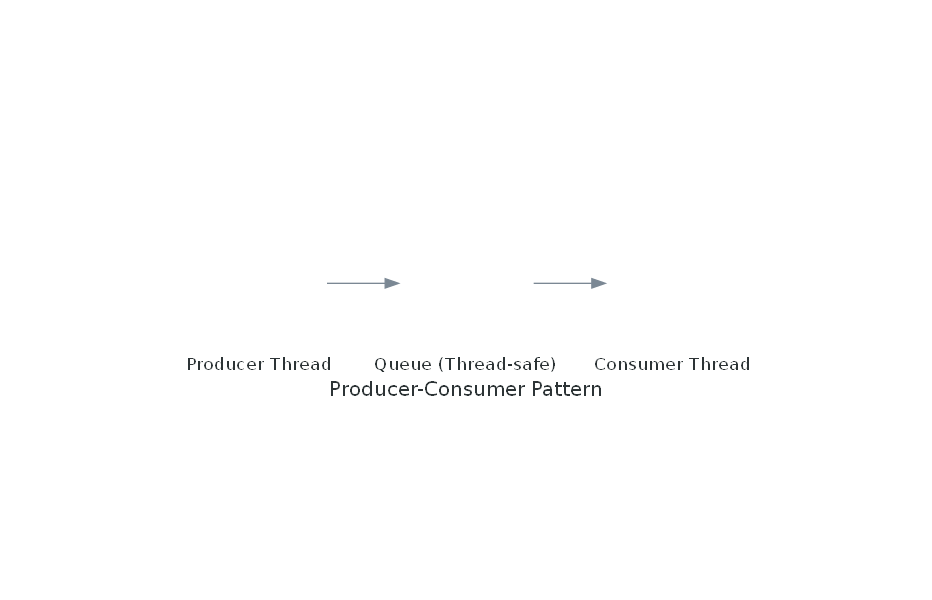

In [35]:
import threading
import time
import queue
from diagrams import Diagram
from diagrams.generic.blank import Blank
from PIL import Image
import IPython.display as display

# === Shared Queue ===
q = queue.Queue()

# === Producer Function ===
def producer():
    for i in range(5):
        item = f"item-{i}"
        print(f"[Producer] Producing {item}")
        q.put(item)
        time.sleep(1)

# === Consumer Function ===
def consumer():
    while True:
        item = q.get()
        if item is None:
            break
        print(f"[Consumer] Consuming {item}")
        time.sleep(2)
        q.task_done()

# === Start Threads ===
prod_thread = threading.Thread(target=producer)
cons_thread = threading.Thread(target=consumer)

prod_thread.start()
cons_thread.start()

prod_thread.join()
q.put(None)  # Sentinel to stop the consumer
cons_thread.join()


with Diagram("Producer-Consumer Pattern", show=False, outformat="png", filename="producer_consumer"):
    p = Blank("Producer Thread")
    qnode = Blank("Queue (Thread-safe)")
    c = Blank("Consumer Thread")

    p >> qnode >> c

img = Image.open("producer_consumer.png")
display.display(img)


In [36]:
# Rate Limiter – Token Bucket Algorithm

[User-0] Allowed request at 1748539246
[User-1] Allowed request at 1748539246
[User-2] Allowed request at 1748539246
[User-1] Allowed request at 1748539246
[User-2] Allowed request at 1748539246
[User-0] Rate limited at 1748539246
[User-0] Allowed request at 1748539247
[User-2] Allowed request at 1748539247
[User-1] Rate limited at 1748539247
[User-1] Rate limited at 1748539247[User-2] Rate limited at 1748539247
[User-0] Rate limited at 1748539247



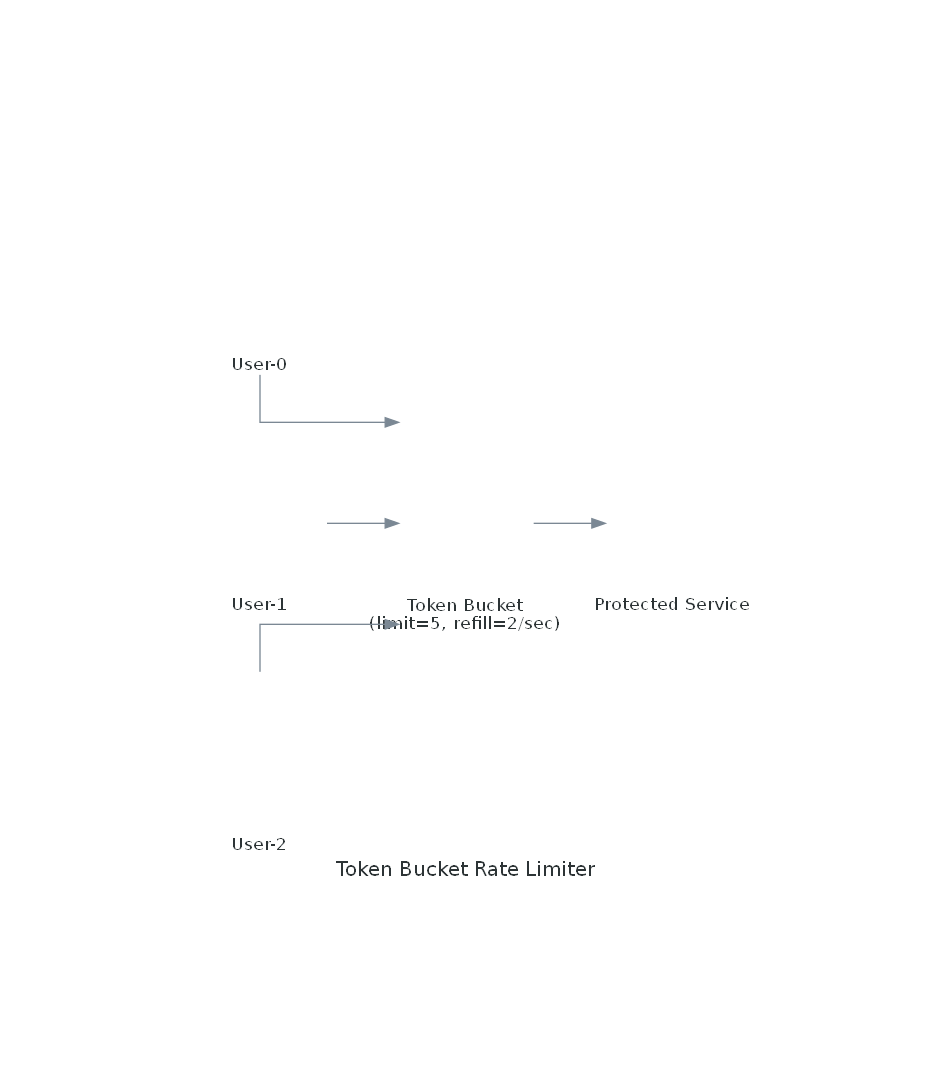

In [37]:
import threading
import time
from collections import deque
from diagrams import Diagram
from diagrams.generic.blank import Blank
from PIL import Image
import IPython.display as display

# === Token Bucket Class ===
class TokenBucket:
    def __init__(self, capacity, refill_rate):
        self.capacity = capacity
        self.tokens = capacity
        self.refill_rate = refill_rate  # tokens per second
        self.lock = threading.Lock()
        threading.Thread(target=self._refill_tokens, daemon=True).start()

    def _refill_tokens(self):
        while True:
            time.sleep(1)
            with self.lock:
                self.tokens = min(self.capacity, self.tokens + self.refill_rate)

    def allow_request(self):
        with self.lock:
            if self.tokens >= 1:
                self.tokens -= 1
                return True
            else:
                return False

# === Simulate API Requests ===
bucket = TokenBucket(capacity=5, refill_rate=2)

def simulate_user(name):
    for i in range(4):
        if bucket.allow_request():
            print(f"[{name}] Allowed request at {time.time():.0f}")
        else:
            print(f"[{name}] Rate limited at {time.time():.0f}")
        time.sleep(0.5)

threads = [threading.Thread(target=simulate_user, args=(f"User-{i}",)) for i in range(3)]
for t in threads: t.start()
for t in threads: t.join()

with Diagram("Token Bucket Rate Limiter", show=False, outformat="png", filename="token_bucket_diagram"):
    users = [Blank(f"User-{i}") for i in range(3)]
    bucket = Blank("Token Bucket\n(limit=5, refill=2/sec)")
    service = Blank("Protected Service")

    for user in users:
        user >> bucket
    bucket >> service

img = Image.open("token_bucket_diagram.png")
display.display(img)


In [38]:
# Backpressure Handling with Queues and Dropping Strategy

[Producer] Pushed: data-0
[Consumer] Processed: data-0
[Producer] Pushed: data-1
[Producer] Pushed: data-2
[Producer] Pushed: data-3
[Consumer] Processed: data-1
[Producer] Pushed: data-4
[Drop] Queue full. Dropping: data-5
[Producer] Pushed: data-5
[Drop] Queue full. Dropping: data-6
[Producer] Pushed: data-6
[Consumer] Processed: data-2
[Producer] Pushed: data-7
[Drop] Queue full. Dropping: data-8
[Producer] Pushed: data-8
[Drop] Queue full. Dropping: data-9
[Producer] Pushed: data-9
[Consumer] Processed: data-3
[Consumer] Processed: data-4
[Consumer] Processed: data-7


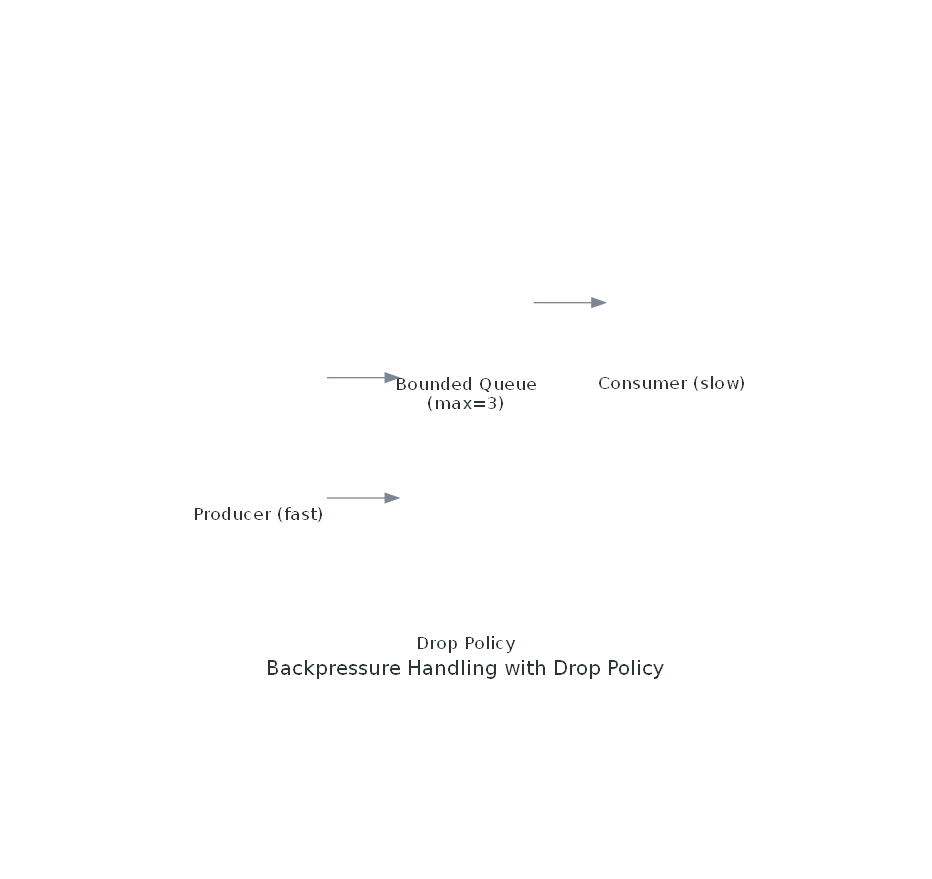

In [39]:
import threading
import time
import queue
from diagrams import Diagram
from diagrams.generic.blank import Blank
from PIL import Image
import IPython.display as display

# === Bounded Queue with Drop Policy ===
class BackpressureQueue(queue.Queue):
    def put(self, item, block=False, timeout=None):
        try:
            super().put(item, block=block, timeout=timeout)
        except queue.Full:
            print(f"[Drop] Queue full. Dropping: {item}")

q = BackpressureQueue(maxsize=3)

# === Producer ===
def producer():
    for i in range(10):
        try:
            q.put_nowait(f"data-{i}")
            print(f"[Producer] Pushed: data-{i}")
        except queue.Full:
            print(f"[Producer] Dropped: data-{i}")
        time.sleep(0.3)

# === Consumer (slow) ===
def consumer():
    while True:
        try:
            item = q.get(timeout=2)
            print(f"[Consumer] Processed: {item}")
            time.sleep(1)
            q.task_done()
        except queue.Empty:
            break

prod = threading.Thread(target=producer)
cons = threading.Thread(target=consumer)

prod.start()
cons.start()
prod.join()
cons.join()

with Diagram("Backpressure Handling with Drop Policy", show=False, outformat="png", filename="backpressure_diagram"):
    p = Blank("Producer (fast)")
    bq = Blank("Bounded Queue\n(max=3)")
    c = Blank("Consumer (slow)")
    drop = Blank("Drop Policy")

    p >> bq >> c
    p >> drop

img = Image.open("backpressure_diagram.png")
display.display(img)


In [40]:
# Idempotency Handling in Distributed Systems

[req1] Processing done.
Processed Order Data
[req2] Processing done.
Processed Order Data
[req1] Duplicate request detected. Returning cached result.
Processed Order Data


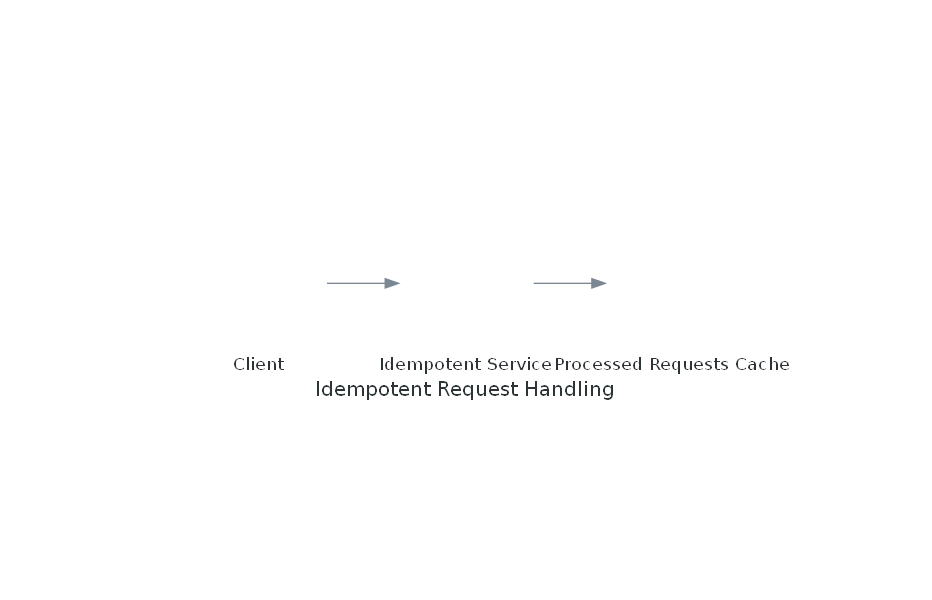

In [41]:
import threading
from time import sleep
from PIL import Image
import IPython.display as display
from diagrams import Diagram
from diagrams.generic.blank import Blank

class IdempotentService:
    def __init__(self):
        self.processed_requests = {}  # store request_id -> result

    def process(self, request_id, payload):
        if request_id in self.processed_requests:
            print(f"[{request_id}] Duplicate request detected. Returning cached result.")
            return self.processed_requests[request_id]
        else:
            # Simulate processing delay
            sleep(1)
            result = f"Processed {payload}"
            self.processed_requests[request_id] = result
            print(f"[{request_id}] Processing done.")
            return result

service = IdempotentService()

# Simulate duplicate requests
for req_id in ["req1", "req2", "req1"]:
    res = service.process(req_id, "Order Data")
    print(res)


with Diagram("Idempotent Request Handling", show=False, outformat="png", filename="idempotency_diagram"):
    client = Blank("Client")
    service = Blank("Idempotent Service")
    cache = Blank("Processed Requests Cache")

    client >> service
    service >> cache

img = Image.open("idempotency_diagram.png")
display.display(img)
